# Определение перспективного тарифа для телеком компании

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Описание данных:
##### Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

##### Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

##### Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

##### Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

##### Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### Шаг 1. Откройте файл с данными и изучите общую информацию.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [17]:
calls = pd.read_csv('/datasets/calls.csv', sep=',')
internet = pd.read_csv('/datasets/internet.csv', sep=',')
messages = pd.read_csv('/datasets/messages.csv', sep=',')
tariffs = pd.read_csv('/datasets/tariffs.csv', sep=',')
users = pd.read_csv('/datasets/users.csv', sep=',')

Получим общую информацию о данных

In [18]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [19]:
calls.head(5)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [20]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [21]:
internet.head(5)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [22]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [23]:
messages.head(5)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [24]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [25]:
tariffs.head(2)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [26]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [27]:
users.head(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


### Вывод

Таблицы содержат подробную информацию о пользователях, тарифах и статистики их использования. Первоначальная проблема, которую необходимо решить это замена типа данных и исправление ошибок в данных по продолжительности звонка и использовании интернет трафика.  Далее для дальнейшего анализа необходимо будет посчитать и добавить в таблицу данные об:
-  количестве сделанных звонков и израсходованных минут разговора по месяцам;
-  количестве отправленных сообщений по месяцам;
-  объеме израсходованного интернет-трафика по месяцам;
-  помесячной выручке с каждого пользователя.

### Шаг 2. Предобработка данных

### Замена типа данных

In [13]:
# <Замена типа данных в таблице users>
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

# <Замена типа данных в таблице calls>
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

# <Замена типа данных в таблице messages>
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

# <Замена типа данных в таблице internet>
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

# <Замена типа данных в таблице tariffs>
tariffs['tariff_name'] = tariffs['tariff_name'].astype('str', errors = 'ignore')

### Исправление ошибок в данных

In [14]:
# <Определим количество звонков длительностью 0 минут>
calls[calls['duration'] == 0]['duration'].count()

39613

In [15]:
# <Определим количество пользователей с 0 использованного трафика>
internet[internet['mb_used'] == 0]['mb_used'].count()

19598

Вероятно, что нулевые значения появились:

- из-за сбоя в системе данные не залогировались;
- из-за не верного округления при выгрузке из информационной системы. 

Заменем нулевые значения на 1 для более точного дальнейшего анализа.

In [16]:
# <Замена нулевых значений в столбце duration таблицы calls>
calls['duration'] = calls['duration'].replace(0, 1)

# <Замена нулевых значений в столбце mb_used таблицы internet>
internet['mb_used'] = internet['mb_used'].replace(0, 1)

 «Мегалайн» всегда округляет вверх значения минут и мегабайтов. По этой причине округлим в большую сторону значения в столбце duration таблицы calls и значений в столбце mb_used таблицы internet.

In [17]:
# <Округление в большую сторону длитольности звонка и объема потраченного трафика>
calls['duration'] = np.ceil(calls['duration'])
internet['mb_used'] = np.ceil(internet['mb_used'])

Для дальнейшего анализа посчитаем для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;

In [18]:
# <Добавим столбец с месяцем в таблицу calls>
calls['month']= calls['call_date'].dt.month

# <Сгруппируем данные по user_id и month>
calls_gr = calls.groupby(['user_id', 'month'])['duration'].sum()
calls_gr = calls_gr.reset_index(level = 'month')

In [19]:
# <Добавим столбец с месяцем в таблицу internet>
internet['month']= internet['session_date'].dt.month

# <Сгруппируем данные по user_id и month>
internet_gr = internet.groupby(['user_id', 'month'])['mb_used'].sum()
internet_gr = internet_gr.reset_index(level = 'month')

In [20]:
# <Добавим столбец с месяцем в таблицу messages>
messages['month']= messages['message_date'].dt.month

# <Сгруппируем данные по user_id и month>
messages_gr = messages.groupby(['user_id', 'month'])['id'].count()
messages_gr = messages_gr.reset_index(level = 'month')

In [21]:
# <Соединим таблицу users с calls и tariffs>
users_calls = users.merge(calls_gr, on='user_id')
users_calls = users_calls.merge(tariffs, left_on='tariff', right_on ='tariff_name')

# <Добавим в таблицу столбец по количеству потраченных минут сверх тарифа>
users_calls['minutes_over_tariff'] = users_calls['duration'] - users_calls['minutes_included']
users_calls['minutes_over_tariff'] = users_calls['minutes_over_tariff'].apply(lambda x: 0 if x < 0 else x)

In [22]:
# <Соединим таблицу users_calls с internet_gr>
users_calls_internet = users_calls.merge(internet_gr, on=['user_id','month'])

# <Добавим в таблицу столбец по количеству потраченных гигабайт сверх тарифа>
users_calls_internet['gb_over_tariff'] = (users_calls_internet['mb_used'] - users_calls_internet['mg_per_month_included']) / 1024
users_calls_internet['gb_over_tariff'] = users_calls_internet['gb_over_tariff'].apply(lambda x: 0 if x < 0 else x)

In [23]:
# <Соединим таблицу users_calls_internet с messages_grs>
users_all = users_calls_internet.merge(messages_gr, on=['user_id','month'])

# <Добавим в таблицу столбец по количеству отправленных сообщений сверх тарифа>
users_all['messages_over_tariff'] = users_all['id'] - users_all['messages_included']
users_all['messages_over_tariff'] = users_all['messages_over_tariff'].apply(lambda x: 0 if x < 0 else x)

Посчитаем помесячную выручку с каждого пользователя:

In [24]:
# <Добавим в таблицу столбец с помесячной выручку с каждого пользователя>
users_all['profit'] = ((users_all['minutes_over_tariff'] * users_all['rub_per_minute'] + users_all['gb_over_tariff'] * users_all['rub_per_gb'] + users_all['messages_over_tariff'] * users_all['rub_per_message']) + users_all['rub_monthly_fee'] ).round(2)

Выведим итоговую таблицу с количеством потраченных минут, гигабайт, сообщений сверх тарифа и полученной вырочкой по каждому пользователю.

In [25]:
# <Выведим итоговую таблицу>
users_all.rename(columns={'id': 'messages', 'duration': 'call_used','id': 'messages_used'}, inplace=True)
users_all[['user_id','month', 'call_used', 'mb_used','messages_used', 'profit', 'tariff_name']].head(10)

,user_id,month,call_used,mb_used,messages_used,profit,tariff_name
0,1000,5,164.0,2257.0,22,1950.0,ultra
1,1000,6,187.0,23262.0,60,1950.0,ultra
2,1000,7,346.0,14017.0,75,1950.0,ultra
3,1000,8,418.0,14072.0,81,1950.0,ultra
4,1000,9,478.0,14583.0,57,1950.0,ultra
5,1000,10,363.0,14717.0,73,1950.0,ultra
6,1000,11,344.0,14769.0,58,1950.0,ultra
7,1000,12,341.0,9829.0,70,1950.0,ultra
8,1003,8,392.0,8572.0,37,1950.0,ultra
9,1003,9,990.0,12479.0,91,1950.0,ultra


### Вывод

Заменили тип данных у столбцов, исправили ошибочные значения и составили итоговую таблицу для дальнейшего анализа.

### Шаг 3. Анализ данных

Создадим сводную таблицу, построим графики и опишим поведение клиентов оператора, в зависимости от тарифа. Узнаем сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц.

In [26]:
# <Создадим сводную таблицу по среднему расходу минут разговора, сообщений, объёма интернет-трафика и выручки>
pd.options.display.float_format = '{:.2f}'.format
users_all_pivot = users_all.pivot_table(index='month', columns='tariff_name' , values=['call_used', 'messages_used', 'mb_used', 'profit'], aggfunc='mean')
users_all_pivot

call_used         mb_used          messages_used        profit  \
tariff_name     smart  ultra    smart    ultra         smart ultra   smart   
month                                                                        
1              216.58 491.00  8701.55 14003.86         20.00 43.43  716.73   
2              319.80 410.29 11960.48 14908.21         27.94 37.29  809.55   
3              403.65 567.72 14666.62 17146.52         35.55 47.80 1094.47   
4              391.90 512.50 13681.60 16839.03         35.86 45.45  947.06   
5              410.90 547.25 16182.61 18954.19         39.03 50.04 1184.64   
6              410.33 511.19 15823.23 18501.90         38.51 50.89 1172.21   
7              420.13 573.67 15851.56 20181.86         38.99 61.29 1189.59   
8              441.46 541.64 16876.71 19410.05         39.04 58.90 1313.70   
9              440.53 579.78 16401.94 19410.79         39.25 63.54 1227.55   
10             439.64 592.54 16803.04 20520.63         39.15 70.76 1327.20   
11             452.69 575.36 17004.61 19735.04         39.96 67.24 1303.98   
12             486.92 657.18 17945.64 22055.14         42.29 72.99 1498.30   

                     
tariff_name   ultra  
month                
1           1950.00  
2           1989.59  
3           2009.48  
4           1962.51  
5           2014.87  
6           2013.50  
7           2069.64  
8           2022.13  
9           1997.50  
10          2058.96  
11          2067.25  
12          2103.67

Построим графики с средним количеством минут разговора, сообщений и объёмом интернет-трафика по тарифам.

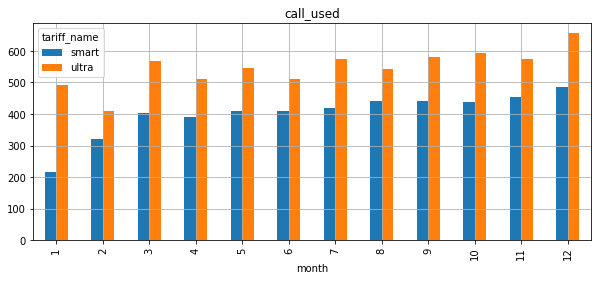

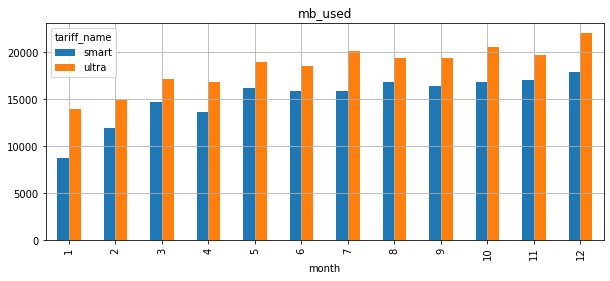

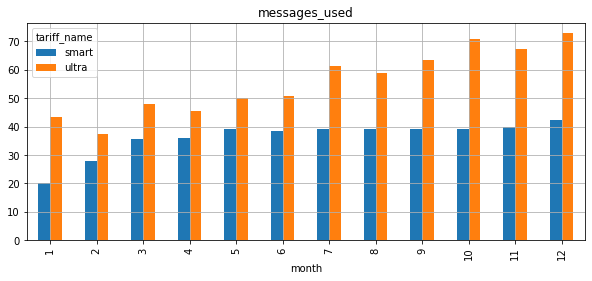

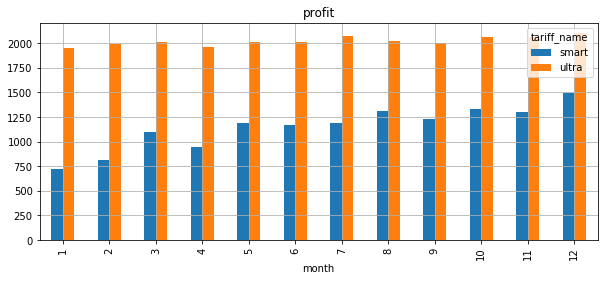

In [27]:
# <Построим графики>
users_all_pivot.plot(title='call_used', y='call_used', style='o-', grid=True, figsize=(10, 4), kind='bar')
users_all_pivot.plot(title='mb_used', y='mb_used', style='o-', grid=True, figsize=(10, 4), kind='bar')
users_all_pivot.plot(title='messages_used', y='messages_used', style='o-', grid=True, figsize=(10, 4), kind='bar')
users_all_pivot.plot(title='profit', y='profit', style='o-', grid=True, figsize=(10, 4), kind='bar')


Посчитаем среднее количество, дисперсию и стандартное отклонение. Построем гистограммы и опишим распределения.

In [28]:
# <Посчитаем среднее и стандартное отклонение для тарифа ultra>
users_all_ultra = users_all.query('tariff_name in "ultra"')[['call_used', 'messages_used', 'mb_used']]
users_all_ultra.describe()

,call_used,messages_used,mb_used
count,752.00,752.00,752.00
mean,571.85,61.64,19616.40
std,319.84,44.82,9638.92
min,1.00,1.00,1.00
25%,341.00,25.00,11917.50
50%,551.50,53.00,19465.00
75%,779.00,89.00,26857.00
max,1727.00,224.00,49793.00


In [29]:
# <Посчитаем среднее и стандартное отклонение для тарифа smart>
users_all_smart = users_all.query('tariff_name in "smart"')[['call_used', 'messages_used', 'mb_used']]
users_all_smart.describe()

,call_used,messages_used,mb_used
count,1915.00,1915.00,1915.00
mean,432.64,38.77,16274.11
std,192.22,26.81,5802.25
min,1.00,1.00,1.00
25%,295.00,17.00,12646.50
50%,440.00,34.00,16495.00
75%,561.50,55.00,20079.50
max,1471.00,143.00,38627.00


In [30]:
# <Посчитаем дисперсию для тарифа ultra>
pd.options.display.float_format = '{:.2f}'.format
variance_ultra = np.var(users_all_ultra, ddof=1)
variance_ultra

call_used         102294.78
messages_used       2008.55
mb_used         92908699.37
dtype: float64

In [31]:
# <Посчитаем дисперсию для тарифа smart>
pd.options.display.float_format = '{:.2f}'.format
variance_smart = np.var(users_all_smart, ddof=1)
variance_smart

call_used          36947.86
messages_used        718.80
mb_used         33666130.53
dtype: float64

Text(0.5, 1.0, 'mb_used_smart')

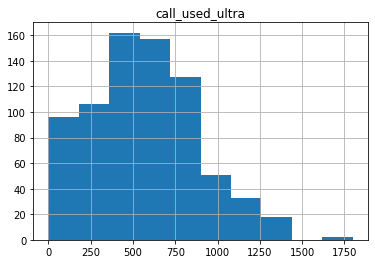

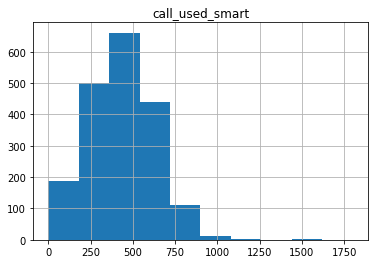

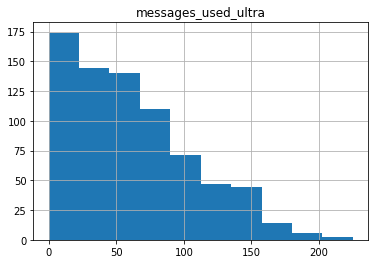

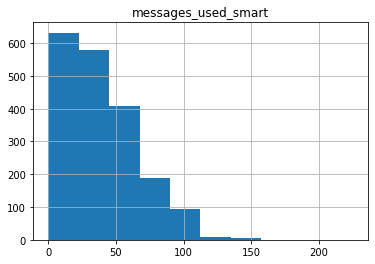

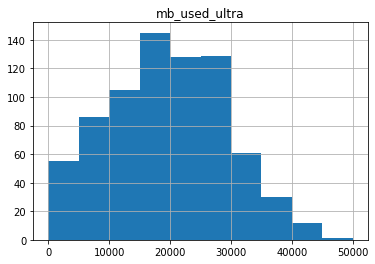

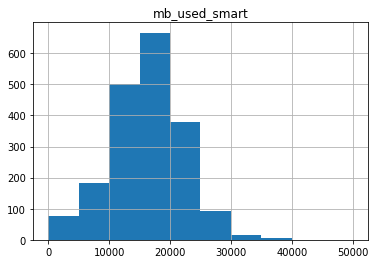

In [32]:
# <Построение гистограмм>
users_all_ultra.hist('call_used',bins=10, range = (0, 1800))
plt.title('call_used_ultra')
users_all_smart.hist('call_used',bins=10, range = (0, 1800))
plt.title('call_used_smart')
users_all_ultra.hist('messages_used',bins=10, range = (0, 225))
plt.title('messages_used_ultra')
users_all_smart.hist('messages_used',bins=10, range = (0, 225))
plt.title('messages_used_smart')
users_all_ultra.hist('mb_used',bins=10, range = (0, 50000))
plt.title('mb_used_ultra')
users_all_smart.hist('mb_used',bins=10, range = (0, 50000))
plt.title('mb_used_smart')

### Вывод

По графикам видно, что на тарифе ultra пользователи в среднем ежемесячно больше расходуют минуты разговора, сообщения и объём интернет-трафика, чем на тарифе smart. При чем заметен явный рост расхода сообщений и объёма интернет-трафика под конец года на тарифе ultra. На тарифе smart явного роста не наблюдается, пользователи ежемесячно в среднем расходуют примерно одинаковой кол-во минут разговора, сообщения и объём интернет-трафика. Средняя выручка на одного пользователя по тарифу ultra примерно в 1,8 раза выше, чем у пользователя по тарифу smart.

### Шаг 4. Проверка гипотез

Проверим 2 гипотезы:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

#### 4.1 Проверим первую гипотезу, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается:

Нулевая гипотезу: средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается.  
Альтернативная гипотеза: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

In [33]:
from scipy import stats as st

smart_test = users_all.query('tariff_name == "smart"')['profit']
ultra_test =  users_all.query('tariff_name == "ultra"')['profit']

alpha = .05 # критический уровень статистической значимости, если pvalue окажется меньше него, отвергнем гипотезу.

results = st.ttest_ind(
    smart_test, 
    ultra_test)
    
print('p-значение: ', results.pvalue)
    
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  2.1726212334409485e-134
Отвергаем нулевую гипотезу


По проверенной гипотезе можно сделать вывод, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается (у тарифа «Ультра» она больше ~ в 1,8 раза). Вероятность получить одинаковые значения по средней выручки очень мала.

#### 4.2 Проверим вторую гипотезу, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов:

Нулевая гипотеза: средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.  
Альтернативная гипотеза: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [34]:
moscow = users_all.query('city == "Москва"')['profit']
other_city =  users_all.query('city != "Москва"')['profit']

alpha = .05 # критический уровень статистической значимости, если pvalue окажется меньше него, отвергнем гипотезу.

results = st.ttest_ind(
    other_city, 
    moscow)
    
print('p-значение: ', results.pvalue)
    
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.10099457739844288
Не получилось отвергнуть нулевую гипотезу


По проверенной гипотезе можно сделать вывод, что средняя выручка пользователей из Москвы сильно не отличается от выручки пользователей из других регионов.  

 Для проверки гипотез использовали двусторонний тест, т.к. в задании вопрос формулировался, как отличаются средние величины и нет разницы в формулировке в задании между гипотезами.

In [35]:
#Пример
moscow = users_all.query('city == "Москва"')['profit']
other_city =  users_all.query('city != "Москва"')['profit']

results = st.ttest_ind(
    other_city, 
    moscow)
    
print('p-значение: ', results.pvalue)
    
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.10099457739844288
Не получилось отвергнуть нулевую гипотезу


Отсортируем данные и найдем ТОП 10 лучших/худших городов по средней выручке на одного пользователя.  

#### ТОП 10 лучших:

In [36]:
# <Сгруппируем данные в таблицу по убыванию прибыли с количество пользователей по городам>
users_all_gr = (users_all
    .groupby(['city']).agg({'profit' : 'mean', 'user_id' : 'count'})
    .reset_index(level = 'city')
)
users_all_gr.sort_values('profit', ascending = False).head(10)

,city,profit,user_id
53,Севастополь,2252.93,4
41,Оренбург,2231.62,4
35,Нижний Новгород,2206.89,36
72,Череповец,2120.47,13
12,Воронеж,2033.51,27
5,Брянск,2023.94,27
26,Курган,1950.00,10
34,Нижневартовск,1950.00,6
15,Иваново,1950.00,2
58,Сургут,1950.00,6


#### ТОП 10 худших:

In [37]:
users_all_gr.sort_values('profit', ascending = False).tail(10)

,city,profit,user_id
37,Новокузнецк,1069.25,48
73,Чита,1054.42,16
42,Орёл,1020.96,18
46,Подольск,951.10,12
10,Волжский,779.19,7
38,Новороссийск,760.92,17
29,Магнитогорск,741.53,25
4,Белгород,727.83,15
69,Химки,610.26,5
59,Тамбов,601.06,23


### Вывод

Обе гипотезы подтвердились. Самая лучшая средняя выручка в городах Севастополь, Оренбург и Нижний Новгород.

### Шаг 5. Общий вывод

По проведенному анализу выявлено, что на тарифе ultra пользователи в среднем ежемесячно больше расходуют минуты разговора, сообщения и объём интернет-трафика, чем на тарифе smart. Были проверены две гипотезы. По первой подтвердилось, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается. Выручка по тарифу ultra на одного пользователя примерно в 1,8 раза приносит больше доход компании, чем тариф smart. По второй гипотезе определили, что средняя выручка пользователей из Москвы сильно не отличается от выручки пользователей из других регионов. Самые худшие города по средней выручке на одного пользователя Новороссикйск, Магнитогорск, Белгород, Химки и Тамбов. Возможно маркетинговому отделу компании стоит запустить какие-нибудь новые акциии в этих городах для привлечения новых клиентов по тарифу ultra.